# Fama–French Three-Factor Model  
### Empirical Asset Pricing with U.S. Stocks

---

## 1. Introduction

The Capital Asset Pricing Model (CAPM) explains expected stock returns using market
risk alone. However, empirical evidence shows that firm characteristics such as
size and value also help explain differences in returns across stocks.

The Fama–French Three-Factor Model extends CAPM by incorporating **size (SMB)** and
**value (HML)** factors. This project applies the Fama–French model to a diversified
set of U.S. stocks and compares its performance to the CAPM using monthly data.

---

## 2. Objective

The objectives of this analysis are to:

- Estimate CAPM and Fama–French three-factor models for individual stocks  
- Examine the statistical significance of estimated alphas  
- Compare model explanatory power across specifications  
- Analyze market, size, and value exposures across firms  

---
## 3. Data

In [1]:
# importing libraries

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# setting display options
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)

In [2]:
# defining tickers and timeframe

tickers = [
    # technology and communication
    "AAPL", "MSFT", "NVDA", "GOOGL", "META",
    # consumer discretionary and staples
    "AMZN", "TSLA", "KO", "WMT",
    # healthcare
    "JNJ", "UNH",
    # financials
    "JPM", "BAC",
    # industrials and energy
    "CAT", "XOM"
]

start_date = "2010-01-01"
end_date = "2026-01-01"

# downloading adjusted close prices
prices = yf.download(
    tickers=tickers,
    start=start_date,
    end=end_date,
    auto_adjust=False,
    progress=False
)["Adj Close"]

# converting to month-end prices and monthly returns
monthly_prices = prices.resample("ME").last()
monthly_returns = monthly_prices.pct_change().dropna(how="all")

# quick checks
display(monthly_prices.tail())
display(monthly_returns.head())
print("Months:", monthly_returns.shape[0])
print("Start:", monthly_returns.index.min().date(), "End:", monthly_returns.index.max().date())

Ticker,AAPL,AMZN,BAC,CAT,GOOGL,JNJ,JPM,KO,META,MSFT,NVDA,TSLA,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,
2025-08-31,231.698380,229.000000,50.198471,416.864197,212.580704,176.052200,298.614685,67.987396,737.600220,505.743439,174.160477,333.869995,305.870789,96.782715,113.299019
2025-09-30,254.145599,219.570007,51.323288,474.672455,242.941101,184.250153,312.494293,65.857430,733.781555,516.982422,186.569611,444.720001,342.993866,102.850342,111.772377
2025-10-31,269.855652,244.220001,53.173672,575.912537,281.006195,187.678391,309.722900,68.419434,647.821655,516.842651,202.478729,456.559998,339.278870,100.974167,113.368416
2025-11-30,278.589325,233.220001,53.372639,574.416077,319.970703,206.919998,311.674103,72.610001,647.421997,492.010010,176.990143,430.170013,327.567596,110.285194,115.919998
2025-12-31,271.605835,230.820007,55.000000,571.532776,313.000000,206.949997,320.773071,69.910004,660.090027,483.619995,186.500000,449.720001,330.109985,111.410004,120.339996


Ticker,AAPL,AMZN,BAC,CAT,GOOGL,JNJ,JPM,KO,META,MSFT,NVDA,TSLA,UNH,WMT,XOM
Date,,,,,,,,,,,,,,,
2010-02-28,0.065396,-0.055897,0.097497,0.092074,-0.005925,0.009895,0.077812,-0.028203,NaN,0.022146,0.052632,NaN,0.026061,0.011978,0.015428
2010-03-31,0.148470,0.146706,0.072080,0.101665,0.076538,0.034921,0.066237,0.051786,NaN,0.021625,0.074074,NaN,-0.035145,0.034093,0.030461
2010-04-30,0.111021,0.009796,-0.001120,0.090131,-0.073036,-0.013803,-0.047427,-0.028182,NaN,0.042677,-0.097127,NaN,-0.071385,-0.035252,0.011795
2010-05-31,-0.016124,-0.084902,-0.117218,-0.107651,-0.076222,-0.085031,-0.070455,-0.038354,NaN,-0.151394,-0.163590,NaN,-0.040910,-0.051944,-0.101806
2010-06-30,-0.020827,-0.129125,-0.086448,-0.011356,-0.083767,0.013036,-0.075038,-0.016654,NaN,-0.108140,-0.222983,NaN,-0.018948,-0.049248,-0.056070


Months: 191
Start: 2010-02-28 End: 2025-12-31


In [3]:
print("META first return:", monthly_returns["META"].first_valid_index())
print("TSLA first return:", monthly_returns["TSLA"].first_valid_index())

META first return: 2012-06-30 00:00:00
TSLA first return: 2010-07-31 00:00:00


In [4]:
# saving data
prices.to_csv("../data/raw/stock_prices_daily.csv")
monthly_returns.to_csv("../data/processed/monthly_returns.csv")

---
## 4. Fama–French Factors

In [5]:
# importing Fama–French factors

from pandas_datareader import data as pdr

# downloading monthly Fama–French 3 factors
ff_factors = pdr.DataReader(
    "F-F_Research_Data_Factors",
    "famafrench",
    start=start_date,
    end=end_date
)[0]

# converting index to month-end timestamps and percentages to decimals
ff_factors.index = ff_factors.index.to_timestamp("M")
ff_factors = ff_factors / 100

# quick check
display(ff_factors.head())
display(ff_factors.tail())

,Mkt-RF,SMB,HML,RF
Date,,,,
2010-01-31,-0.0335,0.0043,0.0033,0.0000
2010-02-28,0.0339,0.0118,0.0318,0.0000
2010-03-31,0.0630,0.0146,0.0219,0.0001
2010-04-30,0.0199,0.0484,0.0296,0.0001
2010-05-31,-0.0790,0.0013,-0.0248,0.0001


,Mkt-RF,SMB,HML,RF
Date,,,,
2025-08-31,0.0184,0.0387,0.0442,0.0038
2025-09-30,0.0339,-0.0185,-0.0105,0.0033
2025-10-31,0.0196,-0.0055,-0.0309,0.0037
2025-11-30,-0.0013,0.0038,0.0376,0.0030
2025-12-31,-0.0036,-0.0106,0.0242,0.0034


---
## 5. Empirical Analysis

In [6]:
# aligning stock returns with Fama–French factors

data = monthly_returns.join(ff_factors, how="inner")

# computing excess stock returns
excess_returns = data[tickers].sub(data["RF"], axis=0)

# quick checks
display(data.tail())
display(excess_returns.tail())
print("Observations:", data.shape[0])

,AAPL,AMZN,BAC,CAT,GOOGL,JNJ,JPM,KO,META,MSFT,NVDA,TSLA,UNH,WMT,XOM,Mkt-RF,SMB,HML,RF
Date,,,,,,,,,,,,,,,,,,,
2025-08-31,0.119639,-0.021827,0.073408,-0.043331,0.109484,0.083346,0.017486,0.016203,-0.044916,-0.048692,-0.020746,0.083044,0.241665,-0.007894,0.033263,0.0184,0.0387,0.0442,0.0038
2025-09-30,0.096881,-0.041179,0.022407,0.138674,0.142818,0.046565,0.046480,-0.031329,-0.005177,0.022223,0.071251,0.332015,0.121368,0.062693,-0.013474,0.0339,-0.0185,-0.0105,0.0033
2025-10-31,0.061815,0.112265,0.036053,0.213284,0.156684,0.018606,-0.008869,0.038902,-0.117146,-0.000270,0.085272,0.026623,-0.010831,-0.018242,0.014279,0.0196,-0.0055,-0.0309,0.0037
2025-11-30,0.032364,-0.045041,0.003742,-0.002598,0.138661,0.102524,0.006300,0.061248,-0.000617,-0.048047,-0.125883,-0.057802,-0.034518,0.092212,0.022507,-0.0013,0.0038,0.0376,0.0030
2025-12-31,-0.025067,-0.010291,0.030491,-0.005020,-0.021785,0.000145,0.029194,-0.037185,0.019567,-0.017053,0.053731,0.045447,0.007761,0.010199,0.038130,-0.0036,-0.0106,0.0242,0.0034


,AAPL,MSFT,NVDA,GOOGL,META,AMZN,TSLA,KO,WMT,JNJ,UNH,JPM,BAC,CAT,XOM
Date,,,,,,,,,,,,,,,
2025-08-31,0.115839,-0.052492,-0.024546,0.105684,-0.048716,-0.025627,0.079244,0.012403,-0.011694,0.079546,0.237865,0.013686,0.069608,-0.047131,0.029463
2025-09-30,0.093581,0.018923,0.067951,0.139518,-0.008477,-0.044479,0.328715,-0.034629,0.059393,0.043265,0.118068,0.043180,0.019107,0.135374,-0.016774
2025-10-31,0.058115,-0.003970,0.081572,0.152984,-0.120846,0.108565,0.022923,0.035202,-0.021942,0.014906,-0.014531,-0.012569,0.032353,0.209584,0.010579
2025-11-30,0.029364,-0.051047,-0.128883,0.135661,-0.003617,-0.048041,-0.060802,0.058248,0.089212,0.099524,-0.037518,0.003300,0.000742,-0.005598,0.019507
2025-12-31,-0.028467,-0.020453,0.050331,-0.025185,0.016167,-0.013691,0.042047,-0.040585,0.006799,-0.003255,0.004361,0.025794,0.027091,-0.008420,0.034730


Observations: 191


In [7]:
# saving data
data.to_csv("../data/processed/merged_data.csv")

In [8]:
# running CAPM and FF3 regressions

import statsmodels.api as sm

results = []
betas = []

for ticker in tickers:
    y = excess_returns[ticker].dropna()

    # aligning factors to the stock's available data
    X_capm = data.loc[y.index, ["Mkt-RF"]]
    X_ff3  = data.loc[y.index, ["Mkt-RF", "SMB", "HML"]]

    X_capm = sm.add_constant(X_capm)
    X_ff3  = sm.add_constant(X_ff3)

    capm_model = sm.OLS(y, X_capm).fit()
    ff3_model  = sm.OLS(y, X_ff3).fit()

    # saving regression summary metrics
    results.append({
        "Ticker": ticker,
        "Alpha_CAPM": capm_model.params["const"],
        "Alpha_CAPM_pval": capm_model.pvalues["const"],
        "Alpha_FF3": ff3_model.params["const"],
        "Alpha_FF3_pval": ff3_model.pvalues["const"],
        "Adj_R2_CAPM": capm_model.rsquared_adj,
        "Adj_R2_FF3": ff3_model.rsquared_adj
    })

    # saving FF3 factor exposures
    betas.append({
        "Ticker": ticker,
        "Beta_Market": ff3_model.params["Mkt-RF"],
        "Beta_SMB": ff3_model.params["SMB"],
        "Beta_HML": ff3_model.params["HML"]
    })

results_df = pd.DataFrame(results).set_index("Ticker")
betas_df = pd.DataFrame(betas).set_index("Ticker")

# quick checks
display(results_df)
display(betas_df)

,Alpha_CAPM,Alpha_CAPM_pval,Alpha_FF3,Alpha_FF3_pval,Adj_R2_CAPM,Adj_R2_FF3
Ticker,,,,,,
AAPL,0.010421,0.024983,0.009040,0.045937,0.350670,0.392842
MSFT,0.007054,0.049308,0.004411,0.175732,0.409621,0.519294
NVDA,0.021916,0.007421,0.019443,0.014177,0.299929,0.353161
GOOGL,0.007254,0.100148,0.005453,0.206265,0.341233,0.379432
META,0.011204,0.163987,0.009641,0.223026,0.180246,0.223320
AMZN,0.008378,0.104502,0.006610,0.149961,0.352212,0.495626
TSLA,0.025053,0.050779,0.028392,0.023057,0.147999,0.212370
KO,0.002598,0.383892,0.000726,0.789451,0.177876,0.327547
WMT,0.006667,0.061217,0.004832,0.161646,0.136681,0.199861


,Beta_Market,Beta_SMB,Beta_HML
Ticker,,,
AAPL,1.123108,-0.216680,-0.478595
MSFT,1.075853,-0.646639,-0.396998
NVDA,1.770230,-0.363642,-0.912140
GOOGL,1.086055,-0.412655,-0.333572
META,1.197878,-0.342920,-0.662051
AMZN,1.245782,-0.105831,-0.997586
TSLA,1.412859,1.340626,-1.197216
KO,0.566686,-0.681229,0.218915
WMT,0.553357,-0.490462,-0.182966


In [9]:
# saving data
results_df.to_csv("../data/processed/regression_results.csv")
betas_df.to_csv("../data/processed/factor_loadings.csv")

---
## Model Explanatory Power

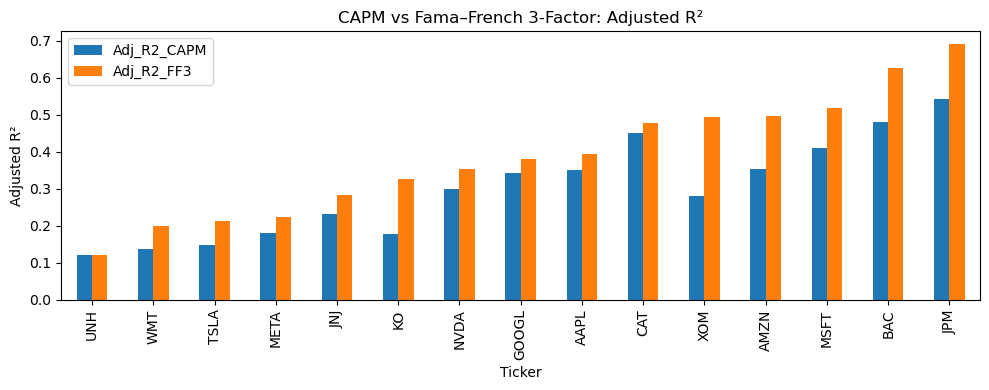

In [10]:
# comparing adjusted R-squared

results_df[["Adj_R2_CAPM", "Adj_R2_FF3"]].sort_values("Adj_R2_FF3").plot(
    kind="bar",
    figsize=(10, 4)
)

plt.title("CAPM vs Fama–French 3-Factor: Adjusted R²")
plt.ylabel("Adjusted R²")
plt.tight_layout()

**Interpretation:**  
Across the stocks, the Fama–French three-factor model exhibits higher adjusted R²
values than the CAPM, indicating that size and value factors provide additional
explanatory power beyond market risk alone.

---
## Market Risk Exposure

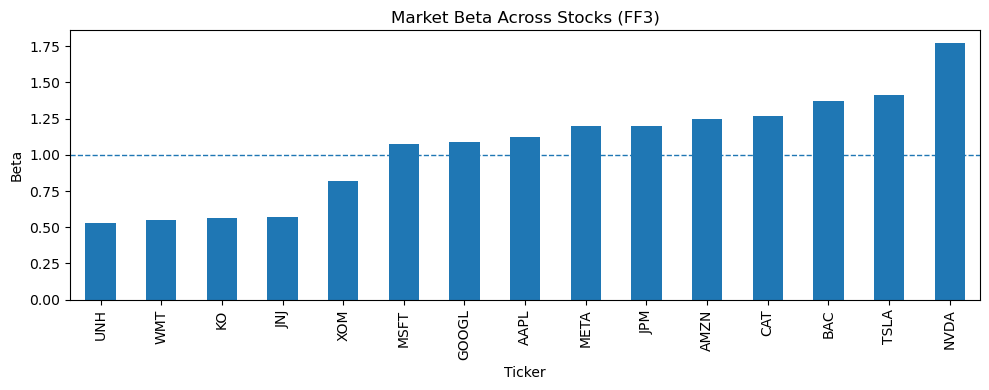

In [11]:
betas_df["Beta_Market"].sort_values().plot(kind="bar", figsize=(10, 4))
plt.axhline(y=1, linestyle="--", linewidth=1)
plt.title("Market Beta Across Stocks (FF3)")
plt.ylabel("Beta")
plt.tight_layout()

**Interpretation:**  
Stocks with market beta above 1 are more sensitive to overall market movements and
can be classified as aggressive, while stocks with beta below 1 exhibit more
defensive behavior. The horizontal reference line at β = 1 highlights this
distinction across firms.

---
## Size Exposure (SMB)

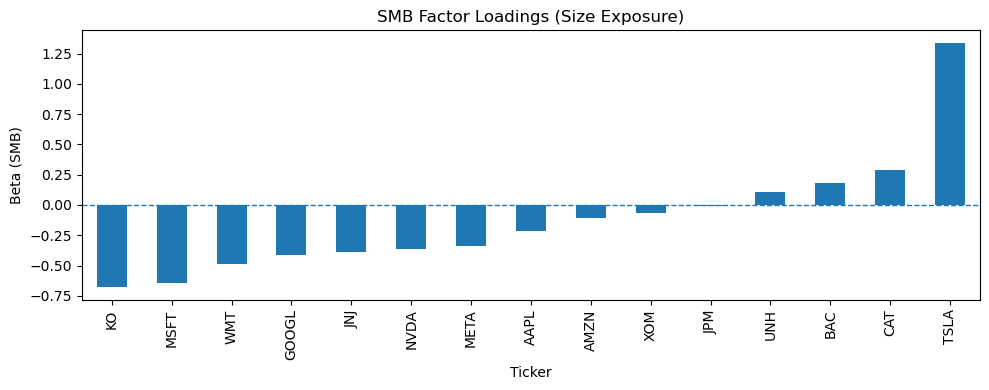

In [12]:
betas_df["Beta_SMB"].sort_values().plot(kind="bar", figsize=(10, 4))

plt.axhline(y=0, linestyle="--", linewidth=1)
plt.title("SMB Factor Loadings (Size Exposure)")
plt.ylabel("Beta (SMB)")
plt.tight_layout()

**Interpretation:**  
SMB loadings indicate the extent to which stocks behave like small-cap or large-cap
firms. Most companies in the sample exhibit negative or near-zero SMB exposures,
consistent with their large-cap classification. However, certain firms—most notably
Tesla—display strong positive SMB loadings, suggesting that their return dynamics
resemble those of smaller, high-growth firms despite their large market
capitalization.

---
## Value vs Growth Characteristics

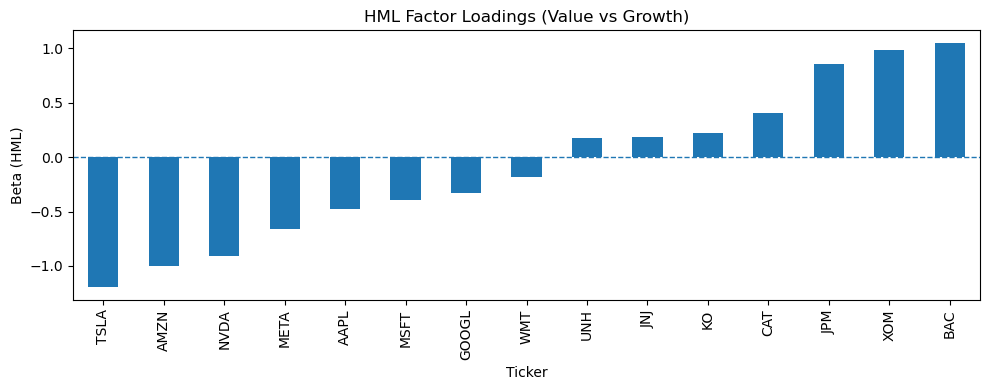

In [13]:
betas_df["Beta_HML"].sort_values().plot(kind="bar", figsize=(10, 4))

plt.axhline(y=0, linestyle="--", linewidth=1)
plt.title("HML Factor Loadings (Value vs Growth)")
plt.ylabel("Beta (HML)")
plt.tight_layout()

**Interpretation:**  
Technology firms, as well as growth-oriented non-technology firms such as Tesla and
Amazon, exhibit negative HML exposures, while more traditional firms display higher
value exposure.

---
## Statistical Significance of Alphas

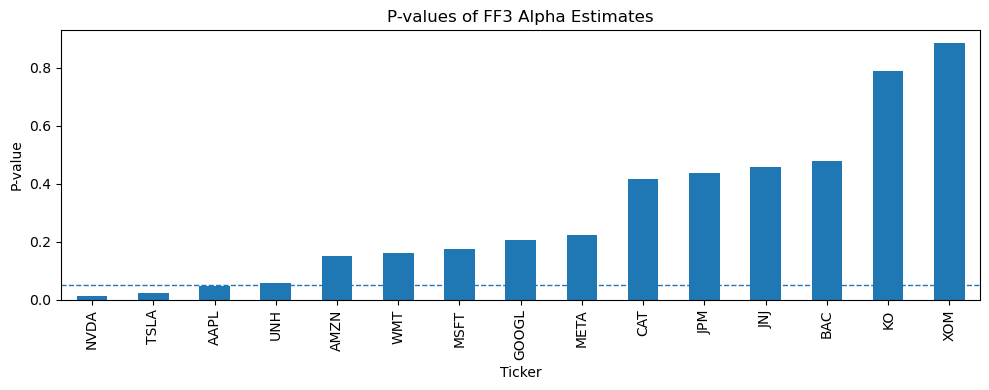

In [14]:
results_df["Alpha_FF3_pval"].sort_values().plot(kind="bar", figsize=(10, 4))

plt.axhline(y=0.05, linestyle="--", linewidth=1)
plt.title("P-values of FF3 Alpha Estimates")
plt.ylabel("P-value")
plt.tight_layout()

**Interpretation:**  
Most stocks exhibit FF3 alpha p-values above 0.05, indicating that abnormal returns
are generally not statistically significant. However, a small number of firms
(e.g., AAPL, NVDA, and TSLA) display statistically significant alphas, suggesting
potential abnormal performance not fully captured by the three-factor model.

## 6. Conclusion

This project examined the ability of the Fama–French three-factor model to explain
monthly stock returns for a diversified set of U.S. equities and compared its
performance to the CAPM.

The results show that the Fama–French model consistently achieves higher adjusted R²
values than the CAPM, indicating that size and value factors provide additional
explanatory power beyond market risk alone. Estimated market betas reveal meaningful
variation in systematic risk across stocks. SMB loadings highlight differences in
size-related return dynamics, with most firms exhibiting large-cap characteristics
and certain high-growth firms displaying stronger small-cap–like behavior. HML
loadings further distinguish growth-oriented firms from value-oriented companies.

An analysis of alpha p-values suggests that abnormal returns are generally not
statistically significant once systematic risk factors are taken into account,
although a small number of firms exhibit statistically significant alphas. Overall,
the findings are consistent with the central insights of modern empirical asset
pricing.